### Decision Trees and Random Forests

#### Packages

In [1]:
import sys
import sklearn
import graphviz
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

print('The Python version is {}.\n'.format(sys.version))
print('The Numpy version is {}.\n'.format(np.__version__))
print('The Pandas version is {}.\n'.format(pd.__version__))
print('The Matplotlib version is {}.\n'.format(mpl.__version__))
print('The Scikit-Learn version is {}.\n'.format(sklearn.__version__))

The Python version is 3.8.5 (default, Jul 28 2020, 12:59:40) 
[GCC 9.3.0].

The Numpy version is 1.19.1.

The Pandas version is 1.1.0.

The Matplotlib version is 3.3.3.

The Scikit-Learn version is 0.24.0.



### Decision Trees

Decision trees and the machine learning models that are based on them, in particular random forests and gradient boosted trees, are fundamentally different types of models than generalized linear models, such as logistic regression. GLMs are rooted in the theories of classical statistics, which have a long history. The mathematics behind linear regression were originally developed at the beginning of the 19th century, by Legendre and Gauss. Because of this, the normal distribution is also called the Gaussian.

Decision trees have an intuitive structure and mimic the way that logical decisions might be made by humans. Therefore, they are a highly interpretable type of mathematical model, which can be a particularly desirable property depending on the audience. 

Decision trees are able to capture non-linear effects of the features, as opposed to a linear relationship.

In general, it should be clear that in a tree with $n$ levels, where every node before the final level is split,
there will be $2n$ leaf nodes. This is important to bear in mind as the maximum depth is one of the hyperparameters that you can set for a decision tree classifier in scikit-learn

#### Growing a tree for the study case

Let us load the data and select the desired columns:

In [2]:
df = pd.read_csv('data/default_of_credit_card_clients_cleaned.csv')

features_response = df.columns.tolist()
to_remove = ['id', 'sex'] + ['pay_{}'.format(i) for i in range(2,7)] + features_response[-6:]

features_response = [feature for feature in features_response if feature not in to_remove]

Let us split the dataset into train and test sets:

In [3]:
X_train, X_test, y_train, y_test = train_test_split(df[features_response].values,
                                                    df.default_payment_next_month.values,
                                                    test_size=0.2, random_state=24)

Now, let us instantiate the decision tree model:

In [4]:
dt = tree.DecisionTreeClassifier(max_depth=2)

dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2)

Using the graphviz library, let display a graphical representation of the tree:

In [5]:
dot_data = tree.export_graphviz(dt, out_file=None, filled=True,
                                rounded=True, feature_names=features_response,
                                proportion=True, class_names=['Not Defaulted', 'Defaulted'])

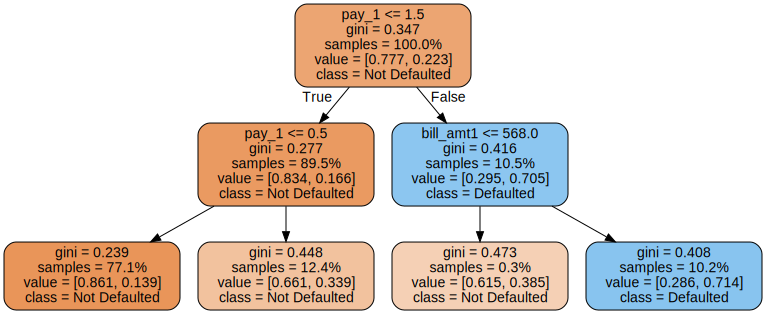

In [6]:
graph = graphviz.Source(dot_data)
graph

The training decision tree worked by starting with all the training samples in the initial node at the top of the tree, and then splited these into two groups based on a **threshold** in one of the features. The cut point was represented by a Boolean condition in the top **pay_1 <= 1.5** node. In the top node, there were all the samples ("samples = 100.0%"). Following the first split, 89.5% of the samples got sorted into the node on the left, while the remaining 10.5% went into the node on the right.

Let us confirm the proportions stated by the model:

In [7]:
(features_response.index('pay_1'),
 X_train.shape)

(4, (21331, 17))

In [8]:
sum(X_train[:, features_response.index('pay_1')] <= 1.5)/X_train.shape[0]

0.8946134733486475

Let us confirm the values line (the class proportion for the first node):

In [9]:
np.mean(y_train)

0.223102526838873

The class fractions were also colored: those with a higher proportion of the negative class than the positive class were orange, with darker orange signifying higher proportions, while those with a higher proportion of the positive class had a similar scheme using a blue color.

The line starting with "class" indicates how the decision tree made predictions from a given node, if that node were a leaf node. 

Decision trees for classification make predictions by determining which leaf node a sample will be sorted in to, given the values of the features, and then predicting the class of the majority of the training samples in that leaf node.

#### Node Impurity

The goal of training decision trees is to make splits so that the next two nodes after the split have a higher purity, or, in other words, are closer to containing either only positive or only negative samples.

In practice, decision trees are actually trained using the inverse of purity, or node impurity. This is some measure of how far the node is from having 100% of the training samples belonging to one class and is analogous to the concept of a cost function, which signifies how far a given solution is from a theoretical perfect solution. For a given node $m$, the misclassification rate is simply the proportion of the less common class in that node, since all these samples will be misclassified when the majority class in that node is taken as the prediction.

The fraction of the positive class for a node $m$ and a class $k$ is given by:

$p_{mk+1} = 1 - p_{mk}$

Let us look at the missclassification distribution:

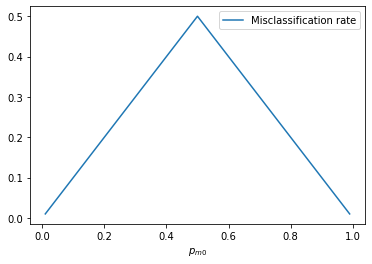

In [10]:
p_m0 = np.linspace(0.01, 0.99, 101)
p_m1 = 1 - p_m0

misclassification_rate = np.minimum(p_m0, p_m1)

plt.plot(p_m0, misclassification_rate, label='Misclassification rate')
plt.xlabel('$p_{m0}$')
plt.legend()

Every time a node is split when growing a decision tree, two new nodes are created. Since the prediction from either of these new nodes is simply the majority class, an important goal will be to reduce the misclassification rate. Therefore, we will want to find a feature, from all the possible features, and a value of this feature at which to make a cut point, so that the misclassification rate in the two new nodes will be as low as possible when averaging over all the classes.

The algorithm then considers each possible threshold for every candidate feature and chooses the one that results in the lowest impurity, calculated as the average impurity across the two possible new nodes, weighted by the number of samples in each node. This process is repeated until a stopping criterion of the tree, such as max_depth.

While the misclassification rate is an intuitive measure of impurity, it happens that there are better measures that can be used to find splits during the model training process. The two options that are available in scikit-learn for the impurity calculation, which you can specify with the criterion keyword argument, are the Gini impurity and the cross-entropy options.

#### Gini

The Gini impurity is calculated for a node $m$ using the following formula:


$$
\begin{equation}
\begin{split}
Gini = \sum_{k} p_{mk} (1 - p_{mk})
\end{split}
\end{equation}
$$

Here, the summation is taken over all classes. In the case of a binary classification problem, there are only two classes, and we can write
this programmatically as follows

#### Cross Entropy

Cross entropy is calculated using this formula:


$$
\begin{equation}
\begin{split}
\text{cross entropy} = - \sum_{k} p_{mk} log(p_{mk})
\end{split}
\end{equation}
$$

Let us see these two distributions:

In [11]:
def gini_impurity(**kwargs):
    """
    Returns the gini impurity for a given array (or arrays)

    Arguments:
        **kwargs (array): Numpy Arrays
    Returns:
        Numpy Array
    """
    return sum([i*(1-i) for i in kwargs.values()])

def cross_entropy_impurity(**kwargs):
    """
    Returns the cross entropy a given array (or arrays)

    Arguments:
        **kwargs (array): Numpy Arrays
    Returns:
        Numpy Array
    """
    return - sum([i*np.log(i) for i in kwargs.values()])

In [12]:
gini = gini_impurity(x1=p_m0, x2=p_m1)
cross_entropy = cross_entropy_impurity(x1=p_m0, x2=p_m1)

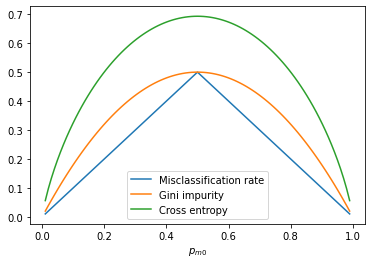

In [13]:
plt.plot(p_m0, misclassification_rate, label='Misclassification rate')
plt.plot(p_m0, gini, label='Gini impurity')
plt.plot(p_m0, cross_entropy, label='Cross entropy')
plt.xlabel('$p_{m0}$')
plt.legend()

Like the misclassification rate, both the Gini impurity and the cross entropy are highest when the class fractions are equal at 0.5, and they decrease as the node becomes purer – in other words, when they contain a higher proportion of just one of the classes. However, the Gini impurity is somewhat steeper than the misclassification rate in certain regions of the class fraction, which enables it to more effectively find the best split. Cross-entropy looks yet steeper.

It is necessary to consider both impurity metrics in a cross-validation search for hyperparameters in order to
determine the appropriate one. Note that in scikit-learn, Gini impurity can be specified with the criterion argument using the 'gini' string, while cross entropy is just referred to as 'entropy'.

#### Greedy Algorithm

There is no guarantee that a decision tree trained by the process described previously will be the best possible decision tree for finding leaf nodes with the lowest impurity. This is because the algorithm used to train decision trees is what is called a greedy algorithm.

The reason why the algorithm is used this way is because it takes substantially longer to consider all possible splits in a way that enables finding the truly optimal tree. Despite this shortcoming of the decision tree training process, there are methods that you can use to reduce the possible harmful effects of the greedy algorithm. Instead of searching for the best split at each node, the splitter keyword argument to the decision tree class can be specified as random in order to choose a random feature to make a split on.

### Decision Trees Pros

#### No need to scale data:

It is not an algorithms based on gradient descent, neither use L1 or L2 regularization to penalize coefficients. The algorithms that use the previous estimations need to scale the features to balance their weights during the training phase.

#### Non-linear relationships and interactions

Because each successive split in a decision tree is performed on a subset of the samples resulting from previous split(s), decision trees can describe complex non-linear relationships of a single feature, as well as interactions between features.

#### Predicted Probabilities

A decision tree makes predictions based on the majority of class of the leaf nodes. The probability is based on the proportion of the majority class in the leaf node. If the leaf node consisted 75% of the positive class, for
example, the prediction for that node will be the positive class and the predicted probability will be 0.75. The predicted probabilities from decision trees are not considered to be as statistically rigorous as those from generalized linear models, but they are still commonly used to measure the performance of models by methods that depend on varying the threshold for classification, such as the ROC curve or the precision-recall curve.

### Finding the best hyperparameters for a D3 model

Let us see the number of samples in the training study case set:

In [14]:
X_train.shape

(21331, 17)

With 21,331 training samples and 4-fold cross-validation, there will be three-fourth of the samples, or about 16,000 samples, in each training fold.

A theoretical limitation is that at least one sample in each leaf is needed. The depth of the tree relates
to the number of leaves, such that a split at every node n, implies 2n leaf nodes. Therefore, a tree with $L$ leaf nodes has a depth of approximately $log_{2}(L)$. In the limiting case, if this tree grow deep enough, so that every leaf node has one training sample for a given fold, the depth will be $log_{2}(16,000) \approx 14$. So, 14 is the theoretical limit to the depth of a tree that could grow in this case.

The depth of 14 would certainly imply overfitting, so this depth is not desired. Let us define different values for the max depth parameter:

In [15]:
params = {'max_depth': [1, 2, 4, 6, 8, 10, 12]}

And now instantiate the GridSearch object:

In [16]:
cv = GridSearchCV(dt, param_grid=params, scoring='roc_auc',
                  n_jobs=None, refit=True, cv=4, verbose=1,
                  pre_dispatch=None, error_score=np.nan, return_train_score=True)

The other options were the ROC AUC metric (scoring='roc_auc'), the 4-fold cross-validation (cv=4), and to calculate training scores (return_train_score=True) to assess the bias-variance trade-off.

Let us fit the data:

In [17]:
cv.fit(X_train, y_train)

Fitting 4 folds for each of 7 candidates, totalling 28 fits


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(max_depth=2),
             param_grid={'max_depth': [1, 2, 4, 6, 8, 10, 12]},
             pre_dispatch=None, return_train_score=True, scoring='roc_auc',
             verbose=1)

And save the dictionary of results in a DataFrame object:

In [18]:
cv_results_df = pd.DataFrame(cv.cv_results_)
cv_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
0,0.032530,0.007054,0.004060,0.000895,1,{'max_depth': 1},0.639514,0.643398,0.651891,0.650753,0.646389,0.005136,7,0.648680,0.647384,0.644553,0.644934,0.646388,0.001712
1,0.051850,0.001237,0.003802,0.000087,2,{'max_depth': 2},0.695134,0.699022,0.713376,0.699510,0.701761,0.006917,5,0.704034,0.702700,0.698113,0.702535,0.701845,0.002232
2,0.101508,0.009389,0.003910,0.000102,4,{'max_depth': 4},0.732720,0.741078,0.746946,0.743731,0.741119,0.005276,2,0.756882,0.752421,0.749368,0.753055,0.752932,0.002673
3,0.143802,0.002191,0.004772,0.000942,6,{'max_depth': 6},0.743836,0.746910,0.751932,0.740517,0.745798,0.004201,1,0.782202,0.780044,0.775228,0.774776,0.778062,0.003158
4,0.188230,0.005357,0.004744,0.000730,8,{'max_depth': 8},0.727023,0.732562,0.750618,0.731040,0.735311,0.009066,3,0.812061,0.808245,0.803415,0.802370,0.806523,0.003890
5,0.225156,0.002811,0.004701,0.000228,10,{'max_depth': 10},0.706871,0.708786,0.717045,0.712074,0.711194,0.003857,4,0.848864,0.853907,0.841430,0.836463,0.845166,0.006704
6,0.259489,0.005075,0.004958,0.000604,12,{'max_depth': 12},0.676996,0.661479,0.676430,0.675982,0.672722,0.006501,6,0.887915,0.903416,0.885891,0.875493,0.888179,0.009980


The DataFrame had one row for each combination of hyperparameters in the grid. As only one hyperparameter is being investigated, there was one row for each of the seven values that were searched for. A lot of output for each row can be seen, such as the mean and standard deviation of the time in seconds that each of the four folds took for both training (fitting) and testing (scoring).

In [19]:
cv_results_df.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_max_depth', 'params', 'split0_test_score', 'split1_test_score',
       'split2_test_score', 'split3_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score', 'split0_train_score',
       'split1_train_score', 'split2_train_score', 'split3_train_score',
       'mean_train_score', 'std_train_score'],
      dtype='object')

Generally speaking, the "best" combination of hyperparameters was the one with the highest average testing score. This was an estimation of how well the model, fit using these hyperparameters, could perform when scored on new data.

Let us display how the average testing score varies with the max_depth hyperparameter, including the standard deviations of the 4-fold training and testing scores as error bars:

Text(0, 0.5, 'ROC AUC')

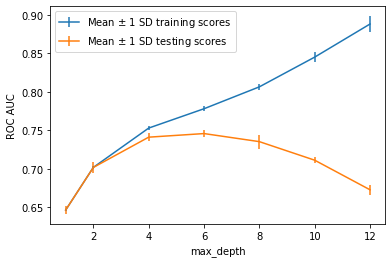

In [20]:
ax = plt.axes()
ax.errorbar(cv_results_df['param_max_depth'],
            cv_results_df['mean_train_score'],
            yerr=cv_results_df['std_train_score'],
            label='Mean $\pm$ 1 SD training scores')
ax.errorbar(cv_results_df['param_max_depth'],
            cv_results_df['mean_test_score'],
            yerr=cv_results_df['std_test_score'],
            label='Mean $\pm$ 1 SD testing scores')
ax.legend()
plt.xlabel('max_depth')
plt.ylabel('ROC AUC')

The standard deviations of the training and testing scores were shown as vertical lines at each value of max_depth that was tried; the distance above and below the average score was 1 standard deviation (they are also in the same units - it would be different when using the variance, which is the std squared). 

The error bars indicated how variable the scores were across folds. There was not much variability between the folds, since the standard deviations were no high, so this was not an issue.

It is possible to see that as the tree's depth grown deeper and deeper, the model fitted the training data better and better. As noted previously, if the model grew trees deep enough so that each leaf node had just one training sample, a model that was very specific to the training data was spotted. In fact, it would fit the training data
perfectly. This model can be said to have an extremely high variance.

The apparent effect of increasing max_depth only increased testing scores up to a point, after which deeper trees had lower testing performance. This is another example of how the bias-variance trade-off can be used to create a better predictive model. In summary, shallower trees had more bias, since they were not fitting the training data as well. This is okay as some bias is acceptable so long a better performance on the testing data is verified.

The best depth for the study case was 6.

Comparing the results with the previous - logistic regression - model, the D3 showed a better performance with an ROC CURVE 0.745, the best performance for the logistic regression - with feature engineering - was 0.740.

### Random Forests

Random forests are examples of what are called ensemble models, because they are formed by combining other models. By combining the predictions of many models, it is possible to improve upon the deficiencies of any given one of them.

Random forests are just ensembles of many decision trees; all the models in this kind of ensemble have the same mathematical form. One hyperparameter, **n_estimators**, needs to be specified when building a random forest model. This parameter counts the number of D3 estimators in the forest. Generally speaking, the more trees, the better. As the number of trees increases, the variance of the overall ensemble will decrease. This should result in the random forest model having better generalization to new data, which will be reflected in increased testing scores.

The variance diminishes when using random forests mainly because of two principles:

#### The number of features considered in each split

By using all the features to fit the training data, overfitting is possible. By limiting the number of features considered at each split, some of the decision trees in a random forest will potentially find better splits. his is because, although they are still greedily searching for the best split, they are doing it with a limited selection of features.

#### The samples used to grow different trees

The other way that the trees in a random forest differ from each other is that they are usually grown with different training samples. To do this, a statistical procedure known as bootstrapping is used, which means to generate new synthetic datasets from the original data. The synthetic datasets are created by randomly selecting samples from the original dataset using replacement. Here, "replacement" means that if we select a certain sample, we will continue to consider it for selection, that is, it is "replaced" to the original dataset after we've sampled it.

The procedure of using random sampling to create synthetic datasets, and training models on them separately, is called bagging,which is short for bootstrapped aggregation.


### Selecting the Best Feautures

After model training, classification trees will take an input sample and a produce a predicted class, for example, whether or not a credit account in our case study problem will default. One intuitive approach to combining the predictions of these trees into the ultimate prediction of the forest is to take a majority vote. Sikit-learn uses a somewhat different approach: adding up the predicted probabilities for each class and then choosing the one with the highest probability. This captures more information from each tree than just the predicted class.

####  Predictions and Interpretability

Random forests are difficult to understand and interpret besides the ranking of the features (that is why it is used as a feature selection sometimes). Although the rank is make available, how the rank was done is difficult to know.

Let us train a Random Forest model:

In [21]:
rf = RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=3,
                            min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0,
                            max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0,
                            min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None,
                            random_state=4, verbose=0, warm_start=False, class_weight=None)

In [22]:
rf_params = {'n_estimators': list(range(10, 110, 10))}

Let us instantiate the cv GridSearch object:

In [23]:
cv_rf = GridSearchCV(rf, param_grid=rf_params, scoring='roc_auc',
                     n_jobs=None, refit=True, cv=4, verbose=1,
                     pre_dispatch=None, error_score=np.nan, return_train_score=True)

And train the model:

In [24]:
cv_rf.fit(X_train, y_train)

Fitting 4 folds for each of 10 candidates, totalling 40 fits


GridSearchCV(cv=4,
             estimator=RandomForestClassifier(max_depth=3, n_estimators=10,
                                              random_state=4),
             param_grid={'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90,
                                          100]},
             pre_dispatch=None, return_train_score=True, scoring='roc_auc',
             verbose=1)

In [25]:
cv_rf_results_df = pd.DataFrame(cv_rf.cv_results_)
cv_rf_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
0,0.165941,0.006219,0.009214,0.000139,10,{'n_estimators': 10},0.739183,0.746599,0.772127,0.771322,0.757308,0.014656,10,0.767973,0.767158,0.760550,0.763683,0.764841,0.002955
1,0.310278,0.004693,0.014494,0.000648,20,{'n_estimators': 20},0.745612,0.753712,0.777616,0.771737,0.762169,0.012998,9,0.772819,0.771499,0.765944,0.765395,0.768914,0.003284
2,0.449935,0.012662,0.020149,0.002076,30,{'n_estimators': 30},0.747259,0.754154,0.777954,0.771825,0.762798,0.012524,7,0.774655,0.772100,0.765026,0.766697,0.769620,0.003910
3,0.595663,0.013271,0.025158,0.002189,40,{'n_estimators': 40},0.746682,0.754553,0.777709,0.773134,0.763020,0.012813,4,0.774300,0.772642,0.765051,0.765876,0.769467,0.004057
4,0.720641,0.005543,0.028281,0.000115,50,{'n_estimators': 50},0.748009,0.755878,0.779465,0.771250,0.763651,0.012379,1,0.775241,0.774025,0.765732,0.766947,0.770486,0.004191
5,0.852607,0.001184,0.033063,0.000228,60,{'n_estimators': 60},0.748437,0.755604,0.779478,0.770978,0.763624,0.012252,2,0.775419,0.773615,0.766133,0.767032,0.770550,0.004031
6,0.993426,0.003056,0.038019,0.000113,70,{'n_estimators': 70},0.747491,0.754465,0.779104,0.771023,0.763021,0.012620,3,0.774420,0.773379,0.765960,0.766174,0.769983,0.003934
7,1.143173,0.005024,0.043118,0.001129,80,{'n_estimators': 80},0.747424,0.754488,0.778753,0.770872,0.762884,0.012502,5,0.774234,0.773257,0.765978,0.766220,0.769922,0.003840
8,1.279748,0.004862,0.049479,0.003227,90,{'n_estimators': 90},0.747097,0.753794,0.778507,0.770426,0.762456,0.012571,8,0.774095,0.772973,0.766022,0.765748,0.769709,0.003846
9,1.416619,0.002662,0.052569,0.000116,100,{'n_estimators': 100},0.747221,0.753924,0.779195,0.770937,0.762819,0.012811,6,0.774340,0.773598,0.766103,0.766914,0.770238,0.003750


Let us display the performance for each gridsearch params:

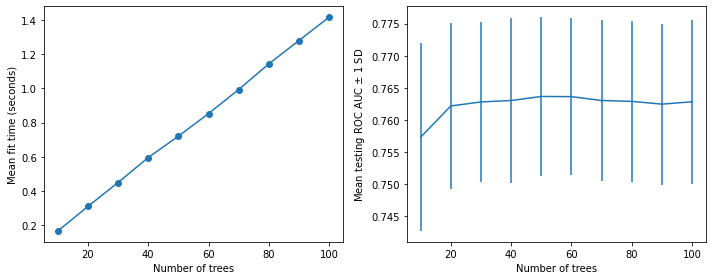

In [26]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

axs[0].plot(cv_rf_results_df['param_n_estimators'],
            cv_rf_results_df['mean_fit_time'],
            '-o')
axs[0].set_xlabel('Number of trees')
axs[0].set_ylabel('Mean fit time (seconds)')

axs[1].errorbar(cv_rf_results_df['param_n_estimators'],
                cv_rf_results_df['mean_test_score'],
                yerr=cv_rf_results_df['std_test_score'])
axs[1].set_xlabel('Number of trees')
axs[1].set_ylabel('Mean testing ROC AUC $\pm$ 1 SD ')
plt.tight_layout()

It is possible to see that by using a random forest, the model performance increased on the cross-validation testing folds compared to the previous models. While no attempt to tune the random forest hyperparameters to achieve the best model performance was done, the results indicated that a random forest was higher in performance compared to previous efforts.

However, along with these higher model testing scores, notice that there was also more variability between the folds saw with the decision tree; this variability was visible as larger standard deviations in model testing scores across the folds.

The left plot shows that there was a linear increase in training time as more trees were added to the forest. This was expected as more trees were evaluated. The additional computation time did not compensate in terms of performance, as beyond 20 trees it was not clear that adding more trees reliably improves testing performance. While the model with 50 trees had the highest score, the fact that adding more trees actually decreased the testing score somewhat indicated that the gain in ROC AUC for 50 trees might just was due to randomness.

Let us see the best hyperparameter as well as the best params estimated by the model:

In [27]:
cv_rf.best_params_

{'n_estimators': 50}

In [28]:
feat_imp_df = pd.DataFrame({
    'Feature name':features_response,
    'Importance':cv_rf.best_estimator_.feature_importances_
})

feat_imp_df.sort_values('Importance', ascending=False)

,Feature name,Importance
4,pay_1,0.609609
11,pay_amt1,0.094123
0,limit_bal,0.079265
13,pay_amt3,0.047067
12,pay_amt2,0.035393
6,bill_amt2,0.022422
14,pay_amt4,0.021164
15,pay_amt5,0.015962
10,bill_amt6,0.014293
8,bill_amt4,0.013454


The top 5 most important features from the random forest were the same as the top 5 chosen by an ANOVA F-test analysis previously done, though in some different order. This was a good confirmation about the importance of these features as they were evaluated by different methods.

### Cross-Validation GridSearch with Random Forest on two hyperparameters

Let us extend the previous exercise and conduct a grid search over the maximum depth of a tree. First, let us create a dictionary representing the grid for **n_estimators** and **max_depth**:

In [29]:
rf_params = {'n_estimators': [10, 50, 100, 200],
             'max_depth': [3, 6, 9, 12]}

And instantiate the GridSearch object using the same options that were applied before and train the predictor (to use parallel computing set **n_jobs=-1** that will match the number of cpus available automatically):

In [30]:
cv_rf = GridSearchCV(rf, param_grid=rf_params, scoring='roc_auc',
                     n_jobs=None, refit=True, cv=4, verbose=2,
                     pre_dispatch=None, error_score=np.nan, return_train_score=True)

cv_rf.fit(X_train, y_train)

Fitting 4 folds for each of 16 candidates, totalling 64 fits
[CV] END .......................max_depth=3, n_estimators=10; total time=   0.2s
[CV] END .......................max_depth=3, n_estimators=10; total time=   0.2s
[CV] END .......................max_depth=3, n_estimators=10; total time=   0.2s
[CV] END .......................max_depth=3, n_estimators=10; total time=   0.2s
[CV] END .......................max_depth=3, n_estimators=50; total time=   0.8s
[CV] END .......................max_depth=3, n_estimators=50; total time=   0.8s
[CV] END .......................max_depth=3, n_estimators=50; total time=   0.8s
[CV] END .......................max_depth=3, n_estimators=50; total time=   0.8s
[CV] END ......................max_depth=3, n_estimators=100; total time=   1.5s
[CV] END ......................max_depth=3, n_estimators=100; total time=   1.5s
[CV] END ......................max_depth=3, n_estimators=100; total time=   1.5s
[CV] END ......................max_depth=3, n_es

GridSearchCV(cv=4,
             estimator=RandomForestClassifier(max_depth=3, n_estimators=10,
                                              random_state=4),
             param_grid={'max_depth': [3, 6, 9, 12],
                         'n_estimators': [10, 50, 100, 200]},
             pre_dispatch=None, return_train_score=True, scoring='roc_auc',
             verbose=2)

Now, let store the results into a pandas DataFrame object:

In [31]:
cv_rf_results_df = pd.DataFrame(cv_rf.cv_results_)
cv_rf_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
0,0.160572,0.010295,0.009034,0.000137,3,10,"{'max_depth': 3, 'n_estimators': 10}",0.739183,0.746599,0.772127,0.771322,0.757308,0.014656,15,0.767973,0.767158,0.760550,0.763683,0.764841,0.002955
1,0.739119,0.014972,0.028264,0.000112,3,50,"{'max_depth': 3, 'n_estimators': 50}",0.748009,0.755878,0.779465,0.771250,0.763651,0.012379,12,0.775241,0.774025,0.765732,0.766947,0.770486,0.004191
2,1.433841,0.013277,0.052308,0.000071,3,100,"{'max_depth': 3, 'n_estimators': 100}",0.747221,0.753924,0.779195,0.770937,0.762819,0.012811,13,0.774340,0.773598,0.766103,0.766914,0.770238,0.003750
3,2.848571,0.006656,0.100138,0.000516,3,200,"{'max_depth': 3, 'n_estimators': 200}",0.747454,0.753057,0.777644,0.771729,0.762471,0.012550,14,0.774453,0.773534,0.766139,0.767404,0.770382,0.003653
4,0.252126,0.002849,0.010875,0.000209,6,10,"{'max_depth': 6, 'n_estimators': 10}",0.752905,0.758904,0.780036,0.774017,0.766466,0.010980,11,0.795911,0.796476,0.793695,0.796446,0.795632,0.001141
5,1.219600,0.008659,0.036014,0.000334,6,50,"{'max_depth': 6, 'n_estimators': 50}",0.760089,0.765251,0.788567,0.778669,0.773144,0.011193,8,0.807081,0.805109,0.799176,0.801229,0.803149,0.003113
6,2.418893,0.007093,0.067700,0.000225,6,100,"{'max_depth': 6, 'n_estimators': 100}",0.760964,0.765515,0.788793,0.778936,0.773552,0.011004,7,0.808194,0.806130,0.800846,0.803123,0.804573,0.002808
7,4.845598,0.009769,0.131047,0.000598,6,200,"{'max_depth': 6, 'n_estimators': 200}",0.761481,0.765319,0.787854,0.779745,0.773600,0.010682,6,0.808276,0.806853,0.800682,0.804006,0.804954,0.002906
8,0.345823,0.001968,0.012519,0.000102,9,10,"{'max_depth': 9, 'n_estimators': 10}",0.757853,0.755444,0.781544,0.773823,0.767166,0.010899,10,0.854161,0.856197,0.850317,0.852039,0.853178,0.002211
9,1.677115,0.008941,0.045137,0.000182,9,50,"{'max_depth': 9, 'n_estimators': 50}",0.763956,0.764420,0.786690,0.780255,0.773830,0.009908,4,0.867242,0.871380,0.868213,0.867390,0.868557,0.001672


Now, let us plot a three dimensional space into a two dimensional plot using a Checkerboard Graph. A Checkerboard Graph plots a two-dimensional grid with colored squares (or other shapes on it) as a way to show three dimensions of data. First, it is necessary to create a meshgrid of the *x*-axis and *y*-axis:

In [32]:
xx_rf, yy_rf = np.meshgrid(range(5), range(5))

Let us set the colour map scale and create the axes:

Text(0, 0.5, 'Maximum depth')

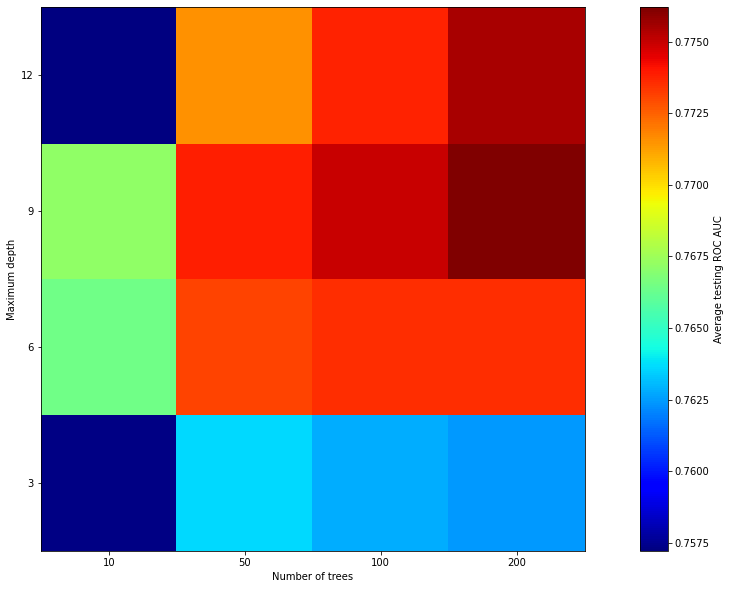

In [33]:
cm = plt.cm.jet

plt.figure(figsize=(20,10))
ax = plt.axes()

pcolor_graph = ax.pcolormesh(xx_rf, 
                             yy_rf, 
                             cv_rf_results_df['mean_test_score'].values.reshape((4,4)), 
                             cmap=cm)

plt.colorbar(pcolor_graph, label='Average testing ROC AUC')

ax.set_aspect('equal')
ax.set_xticks([0.5, 1.5, 2.5, 3.5])
ax.set_yticks([0.5, 1.5, 2.5, 3.5])
ax.set_xticklabels([str(tick_label) for tick_label in rf_params['n_estimators']])
ax.set_yticklabels([str(tick_label) for tick_label in rf_params['max_depth']])
ax.set_xlabel('Number of trees')
ax.set_ylabel('Maximum depth')

There was certainly an advantage to using trees with a depth of more than three. Of the parameter combinations that were tried, **max_depth=9** with **200 trees** yielded the best average testing score, with ROC AUC = 0.776.

This was the best model found so far (compared to the individual D3 and logistic regression).